In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
sns.set()

In [2]:
df = pd.read_csv("../data/data_csv.csv")

In [3]:
df["Year"] = pd.DatetimeIndex(df['Date']).year 

In [4]:
vif = pd.DataFrame()
df_vif = df.drop("Date", axis=1)
vif["features"] = df_vif.columns
vif["vif_Factor"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]

print(vif)
print("\nIf VIF value is higher than 10, it is usually considered having high correlation with other independent variables.")

               features  vif_Factor
0                 SP500  381.962424
1              Dividend  288.972458
2              Earnings  144.001576
3  Consumer Price Index   40.233282
4    Long Interest Rate   11.172129
5            Real Price  386.726001
6         Real Dividend  293.661481
7         Real Earnings  163.017104
8                  PE10   48.355051
9                  Year   68.838492

If VIF value is higher than 10, it is usually considered having high correlation with other independent variables.


### To calculate real returns we use the formula:
return[t] = return[t-1] * (((Real Price[t] - Real Price[t-1]) / Real Price[t-1])) + 1) + (Real Dividend[t-1]/RealPrice[t-1])

In [5]:
def calculate_real_return(start_year, end_year, df_s):
    df_new_s = df_s[(df_s["Year"] >= start_year) & (df_s["Year"] < end_year)].reset_index(drop=True)
    invested_returns = math.log(df_new_s["Real Price"].values[-1]) - math.log(df_new_s["Real Price"].values[0])

    return invested_returns

In [6]:
start_y = 2000
end_y = 2018

previous_real_returns = []

for y in range(start_y, end_y):
    real_return = calculate_real_return(y, y+1, df) 
    previous_real_returns.append(real_return)

In [7]:
return_val = []
year = start_y
i = 0
year_count = []

df_new = df[df.Year>=start_y].reset_index(drop=True)

for idx, row in df_new.iterrows():
    if row.Year == year:
        return_val.append(previous_real_returns[i])
        year_count.append(i)
    else:
        year += 1
        i += 1
        return_val.append(previous_real_returns[i])
        year_count.append(i)

In [8]:
df_new = df_new.drop("Date", axis=1)
df_new["Return"] = return_val
df_new["InvestedYears"] = year_count

(array([ 7., 16., 30., 63., 30., 15., 24., 19.,  8.,  4.]),
 array([ 889.28 , 1070.365, 1251.45 , 1432.535, 1613.62 , 1794.705,
        1975.79 , 2156.875, 2337.96 , 2519.045, 2700.13 ]),
 <a list of 10 Patch objects>)

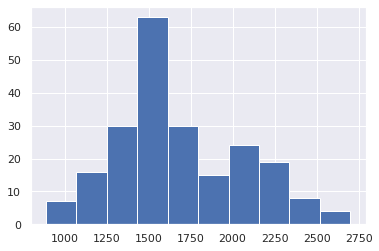

In [9]:
plt.hist(df_new["Real Price"])

(array([24., 24., 24., 12., 24., 24., 12., 24., 24., 24.]),
 array([ 0. ,  1.7,  3.4,  5.1,  6.8,  8.5, 10.2, 11.9, 13.6, 15.3, 17. ]),
 <a list of 10 Patch objects>)

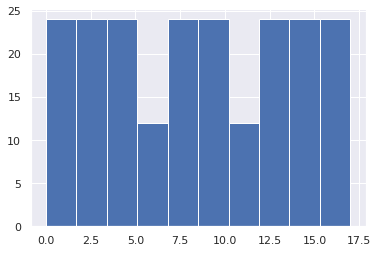

In [10]:
plt.hist(df_new["InvestedYears"])

(array([20., 36., 55., 45.,  9.,  8., 21., 11.,  7.,  4.]),
 array([ 757.13 ,  947.851, 1138.572, 1329.293, 1520.014, 1710.735,
        1901.456, 2092.177, 2282.898, 2473.619, 2664.34 ]),
 <a list of 10 Patch objects>)

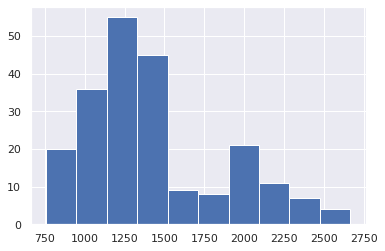

In [11]:
plt.hist(df_new["SP500"])

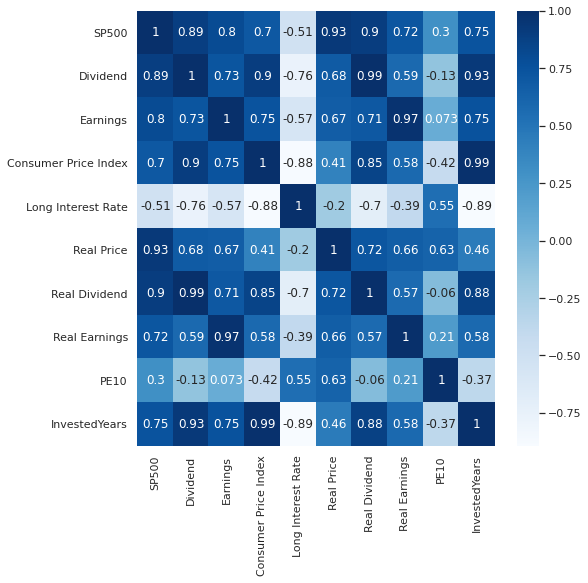

select those independent variables with high correlation with dependent variable


In [12]:
plt.figure(figsize=(8, 8))
sns.heatmap(df_new.drop(["Return", "Year"], axis=1).corr(), annot=True, cmap=plt.cm.Blues)
plt.show()

print("select those independent variables with high correlation with dependent variable")

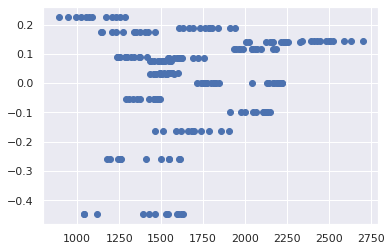

In [13]:
plt.scatter(df_new["Real Price"], df_new["Return"])

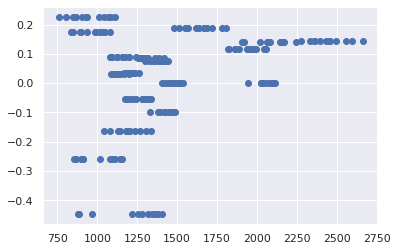

In [14]:
plt.scatter(df_new["SP500"], df_new["Return"])

Text(0, 0.5, 'Log Return')

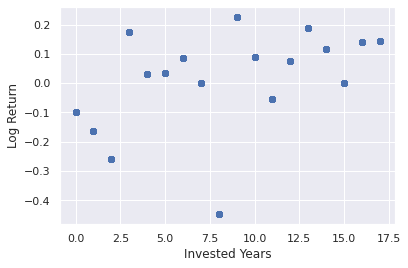

In [15]:
plt.scatter(df_new["InvestedYears"], df_new["Return"])
plt.xlabel("Invested Years")
plt.ylabel("Log Return")

In [16]:
vif = pd.DataFrame()
df_vif = df_new[["SP500", "Real Price"]]
vif["features"] = df_vif.columns
vif["vif_Factor"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]

print(vif)
print("\nIf VIF value is higher than 10, it is usually considered having high correlation with other independent variables.")

     features  vif_Factor
0       SP500   74.213667
1  Real Price   74.213667

If VIF value is higher than 10, it is usually considered having high correlation with other independent variables.


In [17]:
def get_cv_scores(model, x, y):
    scores = cross_val_score(model, x, y, cv=10, scoring='r2')
    
    print(f'CV Mean: {np.mean(scores):.4f}')
    print(f'STD: {np.std(scores):.4f}')

In [18]:
def results(y_t, y_p):
    print(f'Mean squared error: {mean_squared_error(y_t, y_p):.4f}')
    # The coefficient of determination: 1 is perfect prediction
    print(f'Coefficient of determination: {r2_score(y_t, y_p):.4f}')

### Model 1: Return ~ SP500

In [19]:
X = df_new[["SP500"]]
y = df_new[["Return"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

lr = LinearRegression().fit(X_train, y_train)

print("**** Results ****")
get_cv_scores(lr, X_train, y_train)

y_pred = lr.predict(X_test)
results(y_test, y_pred)

**** Results ****
CV Mean: -0.0425
STD: 0.2003
Mean squared error: 0.0345
Coefficient of determination: 0.0759


### Model 2: Return ~ InvestedYears

In [20]:
X = df_new[["InvestedYears"]]
y = df_new[["Return"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

lr = LinearRegression().fit(X_train, y_train)

print("**** Results ****")
get_cv_scores(lr, X_train, y_train)

y_pred = lr.predict(X_test)
results(y_test, y_pred)

**** Results ****
CV Mean: 0.1327
STD: 0.1175
Mean squared error: 0.0303
Coefficient of determination: 0.1879


### Model 3: Return ~ SP500 + InvestedYears

In [21]:
X = df_new[["SP500", "InvestedYears"]]
y = df_new[["Return"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

lr = LinearRegression().fit(X_train, y_train)

print("**** Results ****")
get_cv_scores(lr, X_train, y_train)

y_pred = lr.predict(X_test)
results(y_test, y_pred)

**** Results ****
CV Mean: 0.1425
STD: 0.1226
Mean squared error: 0.0302
Coefficient of determination: 0.1904


### Model 4: Return ~ All features

In [22]:
y = df_new[["Return"]]
X = df_new.drop("Return", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

lr = LinearRegression().fit(X_train, y_train)

print("**** Results ****")
get_cv_scores(lr, X_train, y_train)

y_pred = lr.predict(X_test)
results(y_test, y_pred)

**** Results ****
CV Mean: 0.1148
STD: 0.2803
Mean squared error: 0.0227
Coefficient of determination: 0.3933


In [23]:
X_train_sm = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_sm).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     9.110
Date:                Wed, 21 Oct 2020   Prob (F-statistic):           1.12e-11
Time:                        17:27:51   Log-Likelihood:                 110.37
No. Observations:                 162   AIC:                            -198.7
Df Residuals:                     151   BIC:                            -164.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -5.275e-05   1.03e-05     -5.124      0.000   -7.31e-05   -3.24e-05
SP500                    0.0006      0.001      0.501      0.617      -0.002       0.003
Dividend                 0.0111      0.087      0.128      0.898      -0.161       0.183
Earnings                -0.0246      0.012     -2.075      0.040      -0.048      -0.001
Consumer Price Index    -0.0190      0.005     -3.678      0.000      -0.029      -0.009
Long Interest Rate      -0.0108      0.029     -0.370      0.712      -0.069       0.047
Real Price              -0.0005      0.001     -0.351      0.726      -0.003       0.002
Real Dividend           -0.0194      0.079     -0.245      0.807      -0.176       0.138
Real Earnings            0.0217      0.010      2.188      0.030       0.002       0.041
PE10                    -0.0066      0.024     -0.269      0.788      -0.055       0.042
Year                     0.0017      0.001      3.282      0.001       0.001       0.003
InvestedYears            0.1072      0.021      5.177      0.000       0.066       0.148
==============================================================================
Omnibus:                       12.584   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.336
Skew:                          -0.620   Prob(JB):                      0.00127
Kurtosis:                       3.660   Cond. No.                     1.04e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.37e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### From results above we could see that feature "Invested Years" doesn't improve our model so we could exclude it in future analysis.

## Using PCA to transform features

In [24]:
def transform_features(num_components, X_tr, X_te):
    scaler = MinMaxScaler()
    X_train_minmax = scaler.fit_transform(X_tr)
    X_test_minmax = scaler.transform(X_te)
    
    pca = PCA(n_components=num_components)
    X_train_pca = pca.fit_transform(X_train_minmax)
    X_test_pca = pca.transform(X_test_minmax)
    return pca, X_train_pca, X_test_pca

In [25]:
y = df_new[["Return"]]
X = df_new.drop("Return", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

pca, X_train_pca, X_test_pca = transform_features(0.99, X_train, X_test)

lr = LinearRegression().fit(X_train_pca, y_train)
print("**** Results ****")
get_cv_scores(lr, X_train_pca, y_train)

y_pred = lr.predict(X_test_pca)
results(y_test, y_pred)

**** Results ****
CV Mean: 0.0684
STD: 0.1606
Mean squared error: 0.0298
Coefficient of determination: 0.2020


In [26]:
X_train_sm = sm.add_constant(X_train_pca)
model = sm.OLS(y_train, X_train_sm).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     8.580
Date:                Wed, 21 Oct 2020   Prob (F-statistic):           2.74e-06
Time:                        17:27:51   Log-Likelihood:                 88.147
No. Observations:                 162   AIC:                            -166.3
Df Residuals:                     157   BIC:                            -150.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0229      0.011      2.041      0.043       0.001       0.045
x1             0.0775      0.015      5.200      0.000       0.048       0.107
x2             0.0674      0.033      2.053      0.042       0.003       0.132
x3            -0.0655      0.049     -1.327      0.186      -0.163       0.032
x4            -0.1321      0.116     -1.142      0.255      -0.361       0.096
==============================================================================
Omnibus:                       48.848   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              100.675
Skew:                          -1.365   Prob(JB):                     1.38e-22
Kurtosis:                       5.732   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

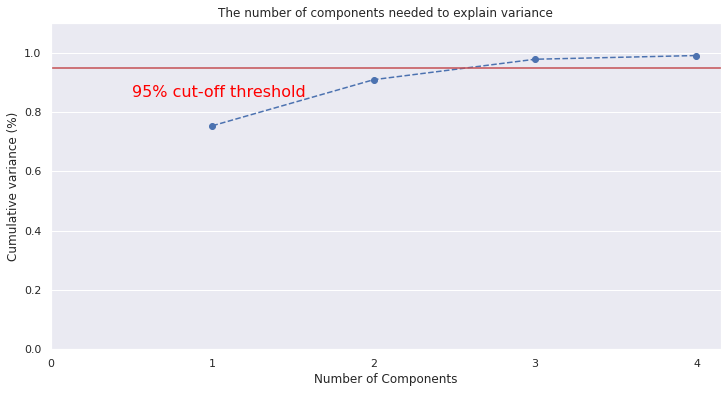

In [27]:
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
end_d = 6 if start_y != 2000 else 5
xi = np.arange(1, end_d, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, end_d, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

### From the plot above we could see that we need 3 components to expalin variance.

### Model 5: Return ~ PCA  with 3 components

In [28]:
y = df_new[["Return"]]
X = df_new.drop("Return", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

pca, X_train_pca, X_test_pca = transform_features(3, X_train, X_test) # try with 3 components

lr = LinearRegression().fit(X_train_pca, y_train)
print("**** Results ****")
get_cv_scores(lr, X_train_pca, y_train)

y_pred = lr.predict(X_test_pca)
results(y_test, y_pred)

**** Results ****
CV Mean: 0.1020
STD: 0.1431
Mean squared error: 0.0303
Coefficient of determination: 0.1886


In [29]:
X_train_sm = sm.add_constant(X_train_pca)
model = sm.OLS(y_train, X_train_sm).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     10.98
Date:                Wed, 21 Oct 2020   Prob (F-statistic):           1.36e-06
Time:                        17:27:51   Log-Likelihood:                 87.478
No. Observations:                 162   AIC:                            -167.0
Df Residuals:                     158   BIC:                            -154.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0229      0.011      2.039      0.043       0.001       0.045
x1             0.0775      0.015      5.195      0.000       0.048       0.107
x2             0.0674      0.033      2.051      0.042       0.002       0.132
x3            -0.0655      0.049     -1.326      0.187      -0.163       0.032
==============================================================================
Omnibus:                       58.225   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              144.050
Skew:                          -1.532   Prob(JB):                     5.25e-32
Kurtosis:                       6.457   Cond. No.                         4.40
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
y_pred.tolist()
y_pred_list = [i[0] for i in y_pred.tolist()]

Text(0, 0.5, 'Return')

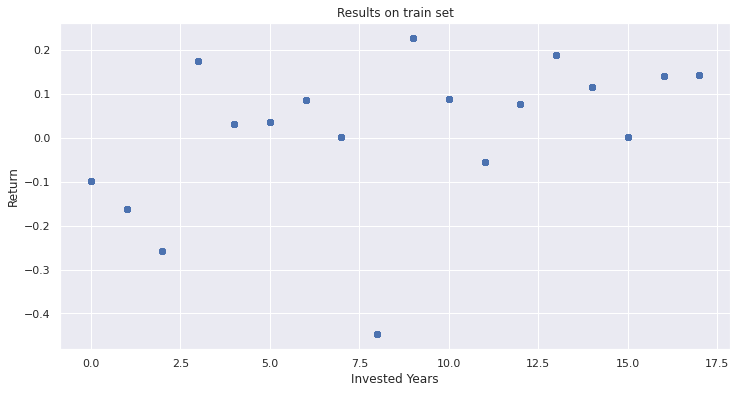

In [31]:
plt.scatter(list(X_train["InvestedYears"]), list(y_train.Return))
plt.title("Results on train set")
plt.xlabel("Invested Years")
plt.ylabel("Return")

Text(0, 0.5, 'Return')

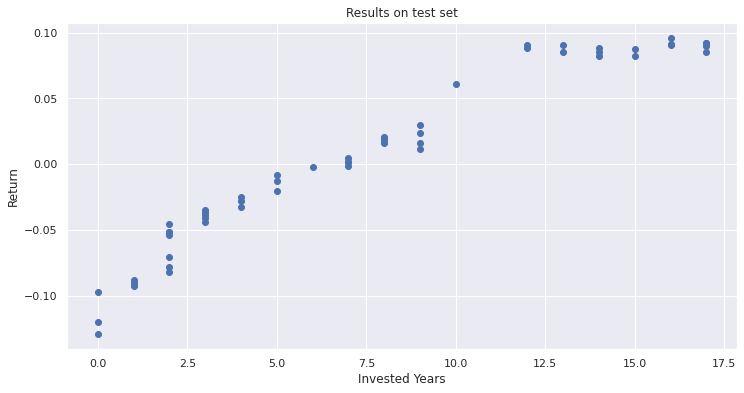

In [32]:
plt.scatter(list(X_test["InvestedYears"]), y_pred_list)
plt.title("Results on test set")
plt.xlabel("Invested Years")
plt.ylabel("Return")

In [33]:
updated_df = pd.read_csv("../data/U.S. Stock Markets 1871-Present.csv")

years = []
for idx, row in updated_df.iterrows():
    years.append(int(str(row["Date"]).split('.')[0]))
    
updated_df["Year"] = years

# we don't have whole year in 2020 so we exclude 2020
start_y = 2018
end_y = 2020
updated_df = updated_df[(updated_df["Year"] >= start_y) & (updated_df["Year"] < end_y)].reset_index(drop=True)

updated_df.drop("Date", axis=1, inplace=True)
updated_df = updated_df.drop(["RealTRScaledEarnings", "Real Total Return Price"], axis=1)

In [34]:
previous_real_returns = []
previous_real_returns.append(1) # start with investing one dollar at the begining
i = 0

for y in range(start_y, end_y):
    real_return = calculate_real_return(y, y+1, updated_df) 
    previous_real_returns.append(real_return)
    i += 1

return_val = []
year = start_y
i = 0
year_count = []

for idx, row in updated_df.iterrows():
    if row.Year == year:
        return_val.append(previous_real_returns[i])
        year_count.append(i)
    else:
        year += 1
        i += 1
        return_val.append(previous_real_returns[i])
        year_count.append(i)

In [35]:
updated_df["Return"] = return_val
updated_df["InvestedYears"] = year_count
updated_df = updated_df.drop("Year", axis=1)

y = updated_df[["Return"]]
X = updated_df.drop("Return", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

pca, X_train_pca, X_test_pca = transform_features(3, X_train, X_test) # try with 3 components

lr = LinearRegression().fit(X_train_pca, y_train)
print("**** Results ****")
y_pred = lr.predict(X_test_pca)
results(y_test, y_pred)

**** Results ****
Mean squared error: 0.0105
Coefficient of determination: 0.9369
